# **Drive mount(공통)**

In [ ]:
# Install keras, tensorflow, and python same as the original git

!pip install keras==2.1.5
!pip install tensorflow==1.6.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
cd 'drive/My Drive/Object_Detection_02'

/content/drive/My Drive/Object_Detection_02


# **Git Download**

In [ ]:
!git clone https://github.com/qqwweee/keras-yolo3.git

Cloning into 'keras-yolo3'...
remote: Enumerating objects: 144, done.
remote: Total 144 (delta 0), reused 0 (delta 0), pack-reused 144
Receiving objects: 100% (144/144), 151.07 KiB | 276.00 KiB/s, done.
Resolving deltas: 100% (65/65), done.


# **Convert Darknet Model To Keras Model (Tiny ver.)**


In [ ]:
# Download tiny yolov3 pretrained weights

!wget https://pjreddie.com/media/files/yolov3-tiny.weights

In [ ]:
# Convert darknet model to keras model

!python convert.py yolov3-tiny.cfg yolov3-tiny.weights model_data/yolo_tiny.h5

In [ ]:
# Test with dog.jpg

from IPython.display import display
from PIL import Image
from yolo import YOLO

def objectDetection(file, model_path, class_path):
    yolo = YOLO(model_path=model_path, classes_path=class_path, anchors_path="model_data/tiny_yolo_anchors.txt")
    image = Image.open(file)
    result_image = yolo.detect_image(image)
    display(result_image)

objectDetection('dog.jpg', 'model_data/yolo_tiny.h5', 'model_data/coco_classes.txt')

# **Convert Labeling Data**

In [ ]:
# Convert annotations

import xml.etree.ElementTree as ET
from os import getcwd
import glob

def convert_annotation(annotation_voc, train_all_file):
    tree = ET.parse(annotation_voc)
    root = tree.getroot()

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1: continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
        train_all_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

train_all_file = open('train_all.txt', 'w')
classes = open('classes.txt').read().splitlines() # 제대로 열었음.

# Get annotations_voc list
for className in classes:
    annotations_voc = glob.glob('new_annotation/*.xml')
    for annotation_voc in annotations_voc:
        image_id = annotation_voc.split('/')[-1].split('.')[0]+'.JPG'
        train_all_file.write('images/%s/%s' %(className, image_id))
        convert_annotation(annotation_voc, train_all_file)
        train_all_file.write('\n')
train_all_file.close()

In [ ]:
# 확인

!ls -al train_all.txt
!head -10 train_all.txt

-rw------- 1 root root 24666 Apr 24 13:09 train_all.txt
images/crack/10041.JPG 1,60,114,98,0 110,85,226,124,0 161,15,224,59,0
images/crack/10039.JPG 2,73,88,121,0 3,116,91,150,0 84,115,223,152,0
images/crack/10038.JPG 4,82,227,190,0
images/crack/10042.JPG 176,1,208,82,0 1,126,227,164,0 57,173,227,211,0
images/crack/10040.JPG 7,130,58,168,0 56,119,225,156,0
images/crack/10045.JPG 3,125,140,150,0 1,146,143,186,0 136,136,227,174,0
images/crack/10043.JPG 3,68,40,114,0 40,106,121,151,0 115,146,226,212,0
images/crack/10046.JPG 4,100,131,147,0 138,69,227,131,0
images/crack/10037.JPG 67,116,223,200,0 1,166,83,220,0
images/crack/10036.JPG 3,124,188,158,0 190,100,226,148,0 3,150,208,199,0 16,206,97,227,0


# **Transfer Learning (Through google colab)**

In [ ]:
import numpy as np
from keras import backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

def _main():
    #경로를 재설정해야함.
    annotation_path = 'train_all2.txt' # 위 Convert Annotation의 결과 파일경로
    log_dir = 'logs/20200623/' # 학습 로그 저장경로
    classes_path = 'classes.txt' # 학습하는 클래스 목록
    anchors_path = 'model_data/tiny_yolo_anchors.txt' # tiny YOLO 모델의 anchors
    #transfer_learning_path = 'model_data/yolo_tiny.h5' # Convert Darknet Model To Keras Model 결과 h5파일
    class_names = get_classes(classes_path)
    num_classes = len(class_names)
    anchors = get_anchors(anchors_path)

    input_shape = (416,416) # multiple of 32, hw
    is_tiny_version = len(anchors)==6 # default setting
    if is_tiny_version:
        model = create_tiny_model(input_shape, anchors, num_classes,
            freeze_body=2, weights_path='tiny_yolo_crack_20200503.h5') # 사용할 weights file? (tiny)
    else:
        model = create_model(input_shape, anchors, num_classes,
            freeze_body=2, weights_path='model_data/yolo_weights.h5')

    logging = TensorBoard(log_dir=log_dir)
    checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
        monitor='val_loss', save_weights_only=False, save_best_only=True, period=1) # save_weights_only=Ture >> False로 바꿔서 Extracting frames out과정에서 load_model에 오류가 없도록 하기 위함.
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

    val_split = 0.1
    with open(annotation_path) as f:
        lines = f.readlines()
    np.random.seed(10101)
    np.random.shuffle(lines)
    np.random.seed(None)
    num_val = int(len(lines)*val_split)
    num_train = len(lines) - num_val

    # Train with frozen layers first, to get a stable loss.
    # Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
    
#    if True:
#       model.compile(optimizer=Adam(lr=1e-3), loss={
#            # use custom yolo_loss Lambda layer.
#            'yolo_loss': lambda y_true, y_pred: y_pred})
#
#        batch_size = 32
#        print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
#        model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
#                steps_per_epoch=max(1, num_train//batch_size),
#                validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
#                validation_steps=max(1, num_val//batch_size),
#                epochs=50,      # modified (original: 50)
#                initial_epoch=0,
#                callbacks=[logging, checkpoint])

#        model.save_weights(log_dir + 'trained_weights_stage_1.h5')

    # Unfreeze and continue training, to fine-tune.
    # Train longer if the result is not good.
    if True:
        for i in range(len(model.layers)):
            model.layers[i].trainable = True
        model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
        print('Unfreeze all of the layers.')

        batch_size = 32 # note that more GPU memory is required after unfreezing the body
        print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
        model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=100,        # modified (original: 100)
            initial_epoch=50, # modified (original: 50)
            callbacks=[logging, checkpoint, reduce_lr, early_stopping])
        model.save_weights(log_dir + 'trained_weights_final.h5')

    # Further training if needed.

def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)


def create_model(input_shape, anchors, num_classes, load_pretrained=True, freeze_body=2,
            weights_path='model_data/yolo_weights.h5'):
    '''create the training model'''
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16, 2:8}[l], w//{0:32, 1:16, 2:8}[l], \
        num_anchors//3, num_classes+5)) for l in range(3)]

    model_body = yolo_body(image_input, num_anchors//3, num_classes)
    print('Create YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2]:
            # Freeze darknet53 body or freeze all but 3 output layers.
            num = (185, len(model_body.layers)-3)[freeze_body-1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))

    model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
        arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.5})(
        [*model_body.output, *y_true])
    model = Model([model_body.input, *y_true], model_loss)

    return model

def create_tiny_model(input_shape, anchors, num_classes, load_pretrained=True, freeze_body=2,
            weights_path='tiny_yolo_crack_20200503.h5'):
    '''create the training model, for Tiny YOLOv3'''
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16}[l], w//{0:32, 1:16}[l], \
        num_anchors//2, num_classes+5)) for l in range(2)]

    model_body = tiny_yolo_body(image_input, num_anchors//2, num_classes)
    print('Create Tiny YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2]:
            # Freeze the darknet body or freeze all but 2 output layers.
            num = (20, len(model_body.layers)-2)[freeze_body-1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))

    model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
        arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.7})(
        [*model_body.output, *y_true])
    model = Model([model_body.input, *y_true], model_loss)

    return model

def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes):
    '''data generator for fit_generator'''
    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(annotation_lines)
            image, box = get_random_data(annotation_lines[i], input_shape, random=True)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
        yield [image_data, *y_true], np.zeros(batch_size)

def data_generator_wrapper(annotation_lines, batch_size, input_shape, anchors, num_classes):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes)

_main()

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:520: FutureWarn

Create Tiny YOLOv3 model with 6 anchors and 1 classes.
Load weights tiny_yolo_crack_20200503.h5.
Freeze the first 42 layers of total 44 layers.
Unfreeze all of the layers.
Train on 4500 samples, val on 500 samples, with batch size 32.
Epoch 51/100
140/140 [==============================] - 6054s 43s/step - loss: 8.2970 - val_loss: 8.5890
Epoch 52/100
 68/140 [=============>................] - ETA: 48:19 - loss: 8.2060

In [ ]:
# <1~50>
# 12epoch
# 10epoch
# 10epoch
# 15epoch

# <51~100>
# 6epoch
# 6epoch
# 6epoch
# 6epoch
# 6epoch
# 4epoch
# 6epoch
# 6epoch
# 6epoch
# 2epoch

**Image 한 장 씩 test**

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:520: FutureWarn

tiny_yolo_crack_20200503.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 1 boxes for img
crack 0.37 (19, 71) (227, 227)
1.102572656999996


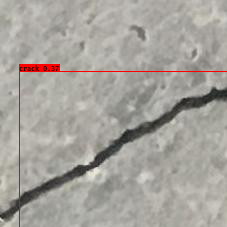

In [ ]:
from IPython.display import display
from PIL import Image
from yolo import YOLO

def objectDetection(file, model_path, class_path):
    yolo = YOLO(model_path=model_path, classes_path=class_path, anchors_path='model_data/tiny_yolo_anchors.txt')
    image = Image.open(file)
    result_image = yolo.detect_image(image)
    display(result_image) 

objectDetection('Crack_Images_voc/Images/05009.jpg', 'tiny_yolo_crack_20200503.h5', 'classes.txt')

**video를 통한 test는 local 환경에서 anaconda를 통해 진행**